# Surface Brightness Profile of Galaxy
Surface Brightness Profile (SBF) shows how light intensity from a source changes with distance from its center. It is plotted as Intensity versus radius.It reveals the object's structure. It is typically modelled by the fuctions like Sersic profile or Exponential Profile.

<p align="center">
  <img src="luminosityprofiles.jpg" width="400">
</p>

#### Exponential Profile
Exponential galaxies have surface brightness profiles described by an equation of form:

$$ \mu(r) = \mu_0 . \exp^{-\beta. \frac{r}{r_e}}$$

where $\mu(r)$ is the surface brightness at radius r, $\mu_0$ is the central brightness and $r_e$ is the `scale length`. $\beta$ is chosen such that one half of the total light of the system would be emitted interior to $r_e$. The `spiral galaxies` generally exhibit exponential surface brightness profile.

#### Sersic Profile
Galaxies with Sersic profiles posses surface brightness profiles described by and equation of form:
$$ \mu(r) = \mu_0 . \exp^{-\beta. \frac{r}{r_e}^{\frac{1}{n}}}$$

where n is the number between 2 and 6, and all other parameters are as above. `Ellipitical galaxies` and `buldges` of spiral galaxies, generallu exhibits sersic brightness profiles with typical n of 4. 

## 1. Importing required Libraries

`astropy` for FITS file handling and units, `photutils` for centroid estimation and aperture photometry and `scipy` for the curve fitting.

In [22]:
# Importing required Libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.centroids import centroid_2dg
from photutils.isophote import EllipseGeometry, Ellipse
from scipy.optimize import curve_fit

## 2. Loading the image data
The galaxy image is loaded from a `FITS` file. FITS (Flexible Image Transport System) is the standard data format used in astronomy for storing image and table data.

It is downloaded form `PanSTARRS-1 Image Access` server. The `r` FITS-cutout of `NGC 2967` is selected for analysis. It is a face-on spiral Galaxy in the constellation Sextans.

#### Background Estimation and Substraction
A simple background substraction is performed by estimating the median pixel value of the image and subtracting it from the data.

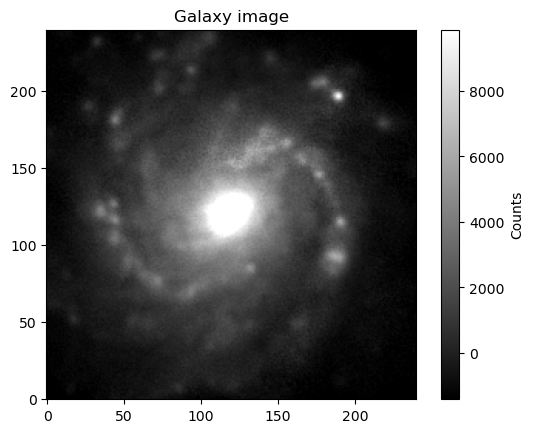

In [23]:
# Load FITS image
hdu = fits.open("/home/ramesh/Documents/Projects/Surface_brightness_profile/ngc_2967.fits")
data = hdu[0].data
hdu.close()
bkg = np.median(data)
data_bkg = data - bkg
plt.imshow(data_bkg, origin='lower', cmap='gray', vmin=np.percentile(data_bkg,5),
           vmax=np.percentile(data_bkg,99))
plt.colorbar(label='Counts')
plt.title("Galaxy image")
plt.show()


## 3. Determining the Galaxy Center
The center of the galaxy is extimated using 2D centroiding method.

In [24]:
y0, x0 = centroid_2dg(data_bkg)
print(x0, y0)

121.32074577937941 117.7922156611733


## 4. Defining Radial Annuli
The galaxy is divided into a series of concentric circular annuli centered on the estimated galaxy center. Each annulus represents a radial bin over which the mean flux is calculated. 

Elliptical isophotes are fitted to the galaxy image using the `photutils.isophote` module.  

In [25]:
geometry = EllipseGeometry(
    x0=x0,
    y0=y0,
    sma=20,            # starting semi-major axis (pixels)
    eps=0.1,          # ellipticity
    pa=0.0            # position angle (radians)
)

ellipse = Ellipse(data_bkg, geometry)
isolist = ellipse.fit_image()

## 5. Surface Brightness Profile
For each annulus, the mean pixel value is computed. This provides a measure of the average brightess at a given radius. The measured mean flux values are plotted as a function of a radius to produce the surface brightness profile.



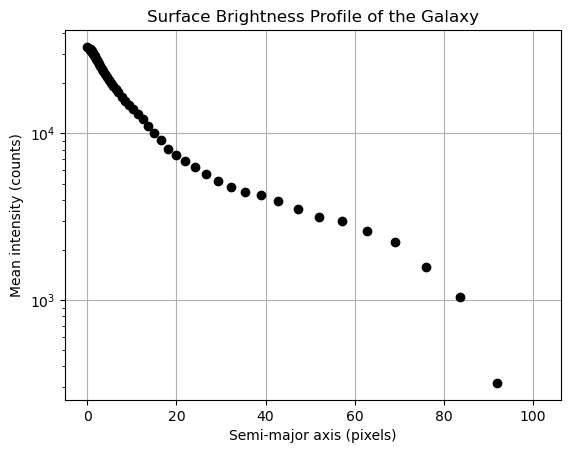

In [26]:
sma = np.array([iso.sma for iso in isolist])
intensity = np.array([iso.intens for iso in isolist])

plt.plot(sma, intensity, 'ko')
plt.xlabel("Semi-major axis (pixels)")
plt.ylabel("Mean intensity (counts)")
plt.yscale('log')
plt.title("Surface Brightness Profile of the Galaxy")
plt.grid(True)
plt.show()


## 6. Analytical Models for Surface Brightness

Two commonly used models are fitted to the surface brightness profile:
- **Exponential Disk Model**: Typically describes spiral galaxy disks
- **Sersic Profile**: A generalized model applicable to all galaxy types

In [27]:
def exponential(r, I0, h):
    return I0 * np.exp(-r/h)

def sersic(r, Ie, re, n):
    bn = 2*n - 0.324
    return Ie * np.exp(-bn * ((r/re)**(1/n) - 1))

In [28]:
p_exp, _ = curve_fit(exponential, sma, intensity, p0=[intensity[0], 20])
p_ser, _ = curve_fit(sersic, sma, intensity, p0=[intensity[0], 20, 1.0])

## 7. Fitted Surface Brightness Curves

The extracted surface brightness profile is fitted using analytical models to quantify the radial light distribution of the galaxy. These fitted curves help interpret the galaxy’s structural properties and morphology.

The fitted curves are overlaid on the observed surface brightness data to visually assess the quality of the fits and to compare how well each model describes the galaxy’s radial brightness distribution. The best-fit Sérsic index is later used to infer the galaxy’s morphological type.


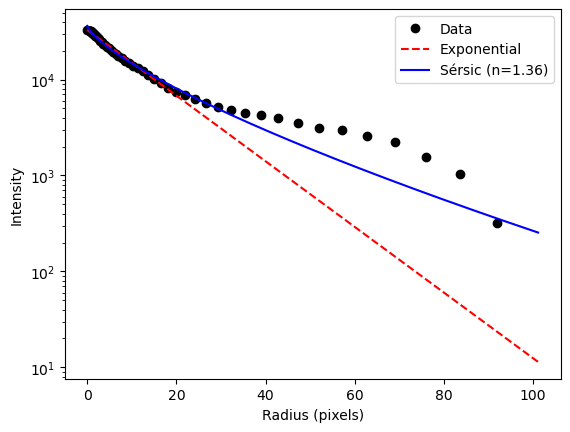

In [29]:
r_fit = np.linspace(min(sma), max(sma), 300)

plt.plot(sma, intensity, 'ko', label='Data')
plt.plot(r_fit, exponential(r_fit, *p_exp), 'r--', label='Exponential')
plt.plot(r_fit, sersic(r_fit, *p_ser), 'b-', label=f'Sérsic (n={p_ser[2]:.2f})')

plt.yscale('log')
plt.xlabel("Radius (pixels)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

## 8. Galaxy Morphological Classification
The Sersic index `n` provides insight into galaxy morphology:
- `n < 1.5`: Disk-Dominated (Spiral)
- `1.5<=n<=3`: Lenticular
- `n > 3`: Elliptical galaxy

note: It is a rough estimation only.

In [30]:
n = p_ser[2]

if n < 1.5:
    print("Likely spiral (disk-dominated)")
elif n < 3.5:
    print("Likely lenticular (S0)")
else:
    print("Likely elliptical galaxy")

Likely spiral (disk-dominated)
